# Can luminosity distribution explain FRB flux distribution?

In [390]:
%matplotlib inline

In [398]:
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import astropy.cosmology as cosmo
import astropy.units as u
import multiprocessing
from contextlib import closing

# optimization produces lots of warning that can be ignored
import warnings
warnings.filterwarnings('ignore')

npr = 8 # number of processes for simulation

## Define functions

In [392]:
def simone(zgrid, vols, lumsim, rate):
    z = np.random.choice(zgrid[:-1], p=vols/vols.sum())  # choose redshift with probablility scaling by volume per bin
    lum = np.random.choice(lumsim, p=rate/rate.sum())  # choose flux with probability scaling by rate
    ff = lum/(4*np.pi*co.luminosity_distance(z).to(u.cm).value**2)  # make a source flux distribution
    return (z, lum, ff)


def simulate(zr, lr, popt, nsim=1000):
    """ Simulate FRBs over redshift range and luminosity range
    FRB distribution should trace volume and lum distribution
    One FRB per source."""
    
    z_min, z_max = zr
    l_min, l_max = lr
    
    # log luminosity grid
    lumsim = np.logspace(np.log10(l_min), np.log10(l_max), 1000)
    # uniform redshift grid
    zgrid = np.linspace(z_min, z_max, 1000)
    # volume per redshift bin
    vols = np.array([co.comoving_volume(zgrid[i+1]).value - co.comoving_volume(zgrid[i]).value
                     for i in range(len(zgrid)-1)])

    # simulate independent sources. one burst per source
    lums = []
    fluxes = []
    zs = []
    rate = plaw(lumsim, *popt)
    for i in range(nsim):
        z, lum, ff = simone(zgrid, vols, lumsim, rate)
        zs.append(z)
        lums.append(lum)
        fluxes.append(ff)
        
    fluxes = np.array(fluxes)
    fluxes.sort()
    lums = np.array(lums)
    lums.sort()
    
    return zs, fluxes, lums


def model(zs, fluxes, lums, top=20, show=True):
    """ Model flux distribution and optionally plots them.
    Returns best fit powerlaw to top flux values.
    """
    
    # fit all fluxes (infinite sensitivity)
    cntf = np.arange(1, len(fluxes)+1)[::-1]
    poptf, pcovf = curve_fit(plaw, fluxes, cntf, sigma=np.sqrt(cntf), p0=(-1, 1e-3))

    # fit high fluxes (sensitivity limit)
    cnth = np.arange(1, top+1)[::-1]
    popth, pcovh = curve_fit(plaw, fluxes[-top:], cnth, sigma=np.sqrt(cnth), p0=(-1, 1e-3))

    # fit luminosities (to confirm sample is right)
#    cntl = np.arange(1, len(lums)+1)[::-1]
    cntl = np.ones_like(lums)
    poptl, pcovl = curve_fit(plaw, lums, cntl, p0=(-1, 1e-3))

    if show:
        print('All: Flux slope {0} and amplitude {1} (at F={2})'.format(poptf[0], poptf[1], fluxes[0]))
        print('Top {0}: flux slope {1} and amplitude {2} (at F={3})'.format(top, popth[0], popth[1], fluxes[-top]))
        print('Luminosities: slope {0} and amplitude {1} (at L={2})'.format(poptl[0], poptl[1], lums[0]))

        pl.figure(figsize=(12,5))
        pl.subplot(131)
        pl.plot(np.log10(fluxes), np.log10(cntf), 'kx', label='Fluxes')
        pl.plot(np.log10(fluxes), np.log10(plaw(fluxes, *poptf)), '-r',
                label='Index (all): {0:.2f}'.format(poptf[0]))
        pl.plot(np.log10(fluxes[-top:]), np.log10(plaw(fluxes[-top:], *popth)), '-r',
                label='Index (top {0}): {1:.2f}'.format(top, popth[0]))
        pl.xlabel('log F (erg/cm2)')
        pl.ylabel('log N (>F)')
        pl.legend()
        pl.subplot(132)
        pl.hist(zs)
        pl.xlabel('redshift')
        pl.ylabel('FRB count')
        pl.subplot(133)
        pl.hist(lums)
        pl.xlabel('Luminosity')
        pl.ylabel('N')
        pl.legend()

    return popth


def simmodel(zr, lr, popt, nsim, top, seed):
    assert nsim >= top, 'Not enough simulations to get top {0} fluxes'.format(top)
    np.random.seed(seed)
    zs, fluxes, lums = simulate(zr, lr, popt, nsim)
    popth = model(zs, fluxes, lums, top=top, show=False)
#    print(seed, popth)
    return popth


def getalphas(res):
    alphas = []    
    while res.keys():
        for i in res.keys():
            if res[i].ready():
                job = res.pop(i)
                try:
                    popth = job.get()
                except RuntimeError:
                    print('curve_fit Runtime Error. Continuing with last result...')
                alphas.append(popth[0])
    alphas = np.array(alphas)
    alphas.sort()
    return alphas

## Model luminosity distribution of FRB 121102

In [393]:
# reference values and functions
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm
plaw = lambda ll, alpha, a: a*(ll/ll[0])**alpha

co = cosmo.Planck15
ld0 = co.luminosity_distance(0.193)

lum0 = np.array([1.5, 12, 0.6, 0.4, 2.1, 0.2, 0.4, 0.6, 0.6])* 1e39
lum0.sort()

Powerlaw slope -0.595096394487 and amplitude 9.74781765219 (at L=2e+38)


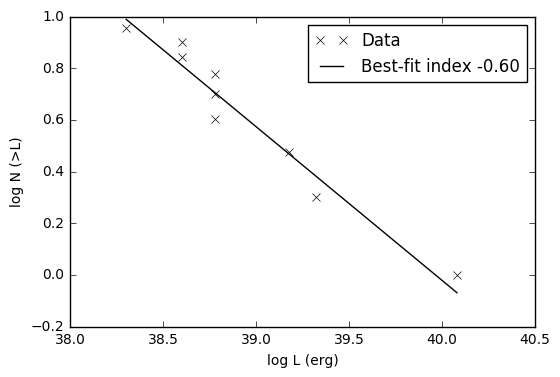

In [394]:
# fit and plot
cnt = np.arange(1,len(lum0)+1)[::-1]
popt0, pcov0 = curve_fit(plaw, lum0, cnt, sigma=np.sqrt(cnt), p0=(-1, 10))
print('Powerlaw slope {0} and amplitude {1} (at L={2})'.format(popt0[0], popt0[1], lum0[0]))

pl.plot(np.log10(lum0), np.log10(cnt), 'kx', label='Data')
pl.plot(np.log10(lum0), np.log10(plaw(lum0, *popt0)), '-k', label='Best-fit index {0:.2f}'.format(popt0[0]))
pl.xlabel('log L (erg)')
pl.ylabel('log N (>L)')
pl.legend()

## Simulation example using "standard candle" FRB

All: Flux slope -1.38114615217 and amplitude 5001.55228462 (at F=3.71013634777e-16)
Top 20: flux slope -1.54592822968 and amplitude 17.5439566145 (at F=1.84196993428e-14)
Luminosities: slope 7.12659226023e-07 and amplitude 0.999999996407 (at L=1e+40)


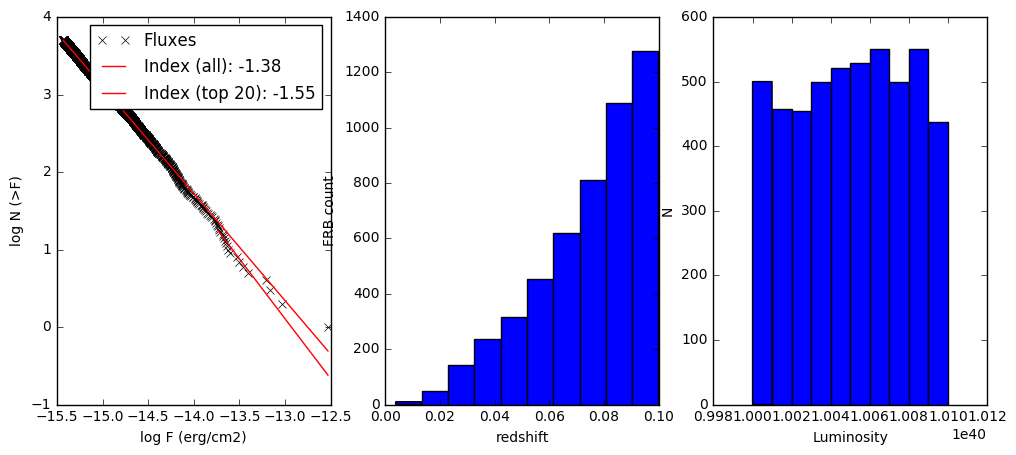

In [399]:
# example using standard candle
zr = 0., 0.1
lr = 1e40, 1.01e40
top = 20
nsim = 5000
popt_std = (0, 10)
zs, fluxes, lums = simulate(zr, lr, popt_std, nsim=nsim)
popth = model(zs, fluxes, lums, top=top)

## Test change with z_max

In [ ]:
lr = 1e40, 1.01e40
popt_std = (0, 10)
z_min = 0.
ntr = 100
nsim = 200
top = 20
ci = 0.68

a_ci_std = {}
for z_max in np.linspace(0.1, 2., 5):
#    zs, fluxes, lums = simulate((z_min, z_max), lr, popt_std, nsim=100)
#    popth = model(zs, fluxes, lums, show=False)
#    alphas.append(popth[0])

    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, ( (z_min, z_max), lr, popt_std, nsim, top, trial))
        alphas = getalphas(res)
        
    a_ci_std[z_max] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

In [ ]:
for key in a_ci_std:
    val = a_ci_std[key]
    pl.plot([key, key], list(a_ci_std[key]), 'k.-' )
    pl.title('Standard Candle')
    pl.xlabel('Max Redshift')
    pl.ylabel('Flux distribution index')

## Test change of L distribution to powerlaw

In [9]:
lr = 1e35, 1e45
z_min = 0.
ntr = 100
nsim = 2000
ci = 0.68
top = 20

a_ci = {}
for z_max in np.linspace(0.01, 2., 5):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, ( (z_min, z_max), lr, popt0, nsim, top, trial))
        alphas = getalphas(res)
 
    a_ci[z_max] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

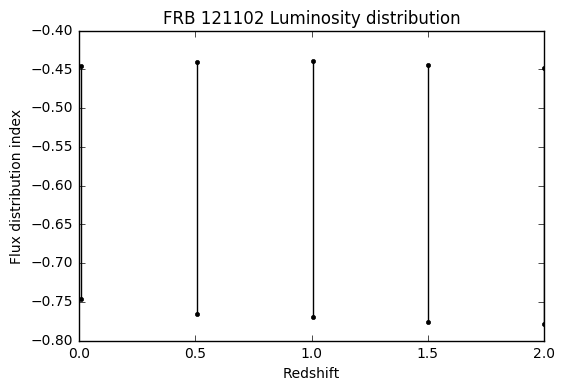

In [10]:
for key in a_ci:
    val = a_ci[key]
    pl.plot([key, key], list(a_ci[key]), 'k.-' )
    pl.title('FRB 121102 Luminosity distribution')
    pl.xlabel('Redshift')
    pl.ylabel('Flux distribution index')

## Test for change in L_max of distribution

In [11]:
l_min = 1e38
zr = 0., 0.01
ntr = 100
nsim = 200
top = 20
ci = 0.68

a_ci2 = {}
for l_max in np.logspace(np.log10(l_min)+1, np.log10(l_min)+5, 5):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, ( zr, (l_min, l_max), popt0, nsim, top, trial))
        alphas = getalphas(res)

    a_ci2[l_max] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

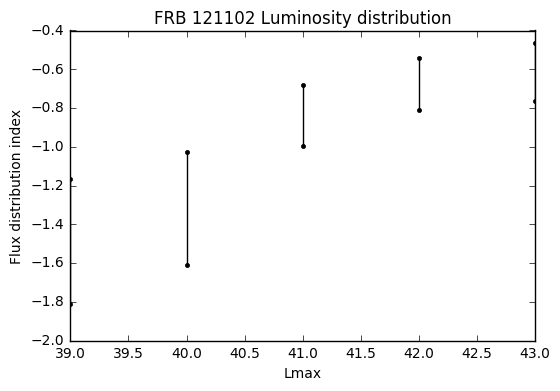

In [12]:
for key in a_ci2:
    val = a_ci2[key]
    pl.plot([np.log10(key), np.log10(key)], list(a_ci2[key]), 'k.-' )
    pl.title('FRB 121102 Luminosity distribution')
    pl.xlabel('Lmax')
    pl.ylabel('Flux distribution index')

## Test sensitivity to number of FRBs simulated

In [13]:
l_min = 1e38, 1e43
zr = 0., 0.4
ntr = 100
top = 20
ci = 0.68
a_ci3 = {}
for nsim in np.logspace(2,3.5,4):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, popt0, int(nsim), top, trial))
        alphas = getalphas(res)

    a_ci3[nsim] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

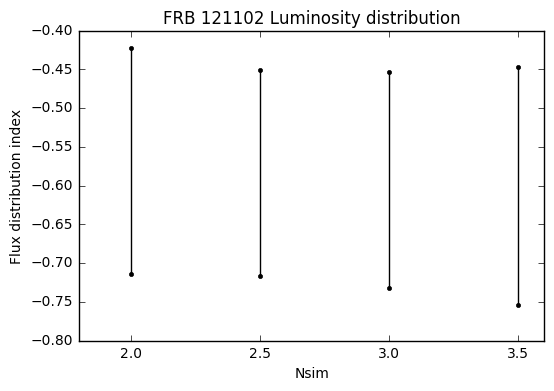

In [14]:
for key in a_ci3:
    val = a_ci3[key]
    pl.plot([np.log10(key), np.log10(key)], list(a_ci3[key]), 'k.-' )
    pl.title('FRB 121102 Luminosity distribution')
    pl.xlabel('Nsim')
    pl.ylabel('Flux distribution index')

## Test sensitivity to number of FRBs above "flux limit"

In [16]:
lr = 1e38, 1e43
zr = 0., 0.4
ntr = 100
nsim = 1000
ci = 0.68
a_ci4 = {}
for top in np.logspace(1,2.5,4):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, popt0, nsim, int(top), trial))
        alphas = getalphas(res)

    a_ci4[top] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

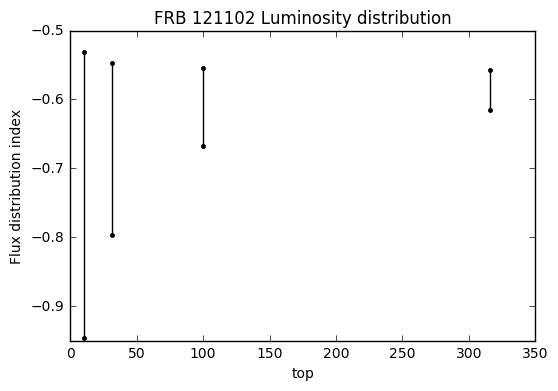

In [17]:
for key in a_ci4:
    val = a_ci4[key]
    pl.plot([key, key], list(a_ci4[key]), 'k.-' )
    pl.title('FRB 121102 Luminosity distribution')
    pl.xlabel('top')
    pl.ylabel('Flux distribution index')

## Test top relative to nsim

In [18]:
lr = 1e38, 1e43
zr = 0., 0.4
ntr = 100
ci = 0.68
top = 20
a_ci5 = {}
for nsim in np.logspace(1.5,3.5,4):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, popt0, int(nsim), top, trial))
        alphas = getalphas(res)

    a_ci5[int(nsim)] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

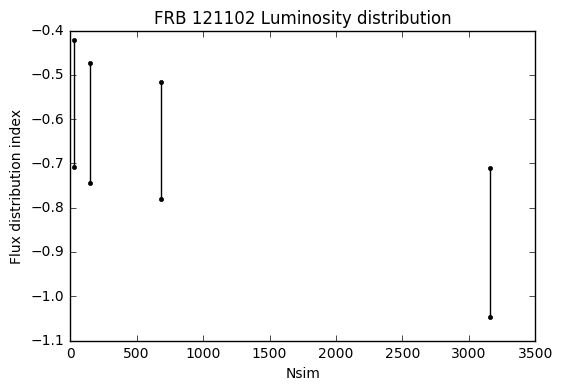

In [19]:
for key in a_ci5:
    val = a_ci5[key]
    pl.plot([key, key], list(a_ci5[key]), 'k.-' )
    pl.title('FRB 121102 Luminosity distribution')
    pl.xlabel('Nsim')
    pl.ylabel('Flux distribution index')

## Change input luminosity powerlaw

In [20]:
lr = 1e38, 1e43
zr = 0., 0.4
ntr = 200
nsim = 500
top = 20
ci = 0.68

a_ci6 = {}
for alpha_sim in [-2,-1.,0.,1.]:
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, (alpha_sim, popt0[1]), nsim, top, trial))
        alphas = getalphas(res)

    a_ci6[alpha_sim] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

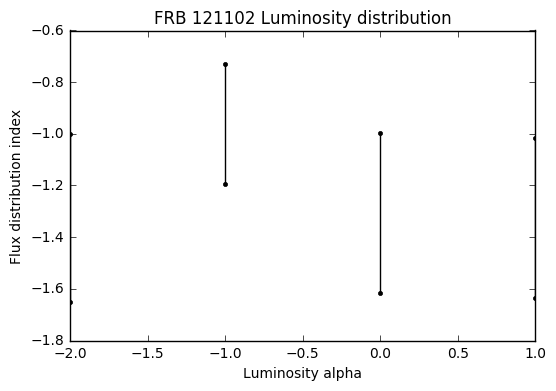

In [21]:
for key in a_ci6:
    val = a_ci6[key]
    pl.plot([key, key], list(a_ci6[key]), 'k.-' )
    pl.title('FRB 121102 Luminosity distribution')
    pl.xlabel('Luminosity alpha')
    pl.ylabel('Flux distribution index')

## Single 95% confidence intervals with parameters safe from edge effects

In [22]:
lr = 1e38, 1e42  # safe from edge effects
zr = 0., 0.4  # safe from edge effects
ntr = 200  # safe from edge effects
nsim = 500
top = 20
ci = 0.95

res = {}
with closing(multiprocessing.Pool(npr)) as pool:
    for trial in range(ntr):
        res[trial] = pool.apply_async(simmodel, (zr, lr, popt0, nsim, top, trial))
    alphas = getalphas(res)

95% ci: -1.08543774281 to -0.532460987816
68% ci: -0.892483820051 to -0.627664619281
Example distribution:
All: Flux slope -0.503015596185 and amplitude 583.862103725 (at F=1.95531567235e-19)
Top 20: flux slope -0.856192185924 and amplitude 18.9758504365 (at F=7.64213154123e-17)
Luminosities: slope 1.67190433865e-09 and amplitude 0.999999997363 (at L=1e+38)


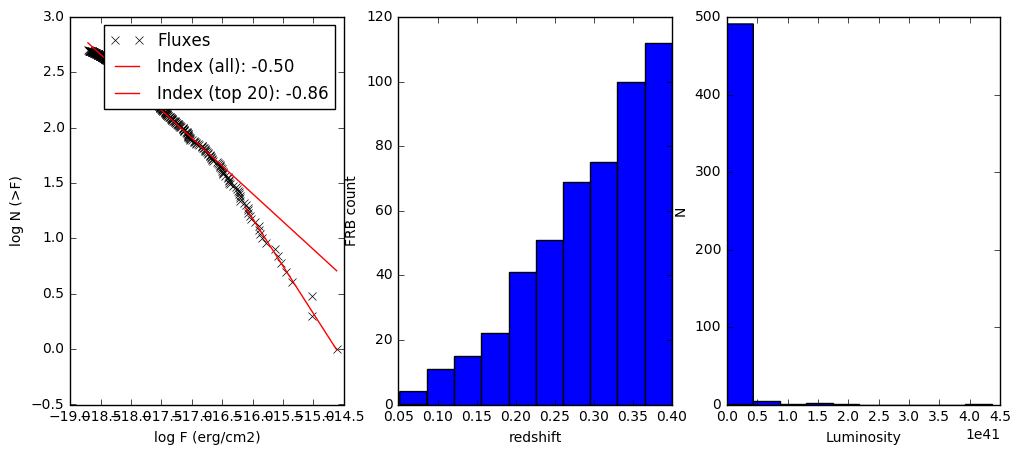

In [23]:
ci = 0.95
print('95% ci: {0} to {1}'.format(alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)]))
ci = 0.68
print('68% ci: {0} to {1}'.format(alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)]))
print('Example distribution:')
zs, fluxes, lums = simulate(zr, lr, popt0, nsim)
popth = model(zs, fluxes, lums, top=top, show=True)